100%|██████████| 100/100 [00:01<00:00, 63.90it/s]


Test Accuracy: 85.83%


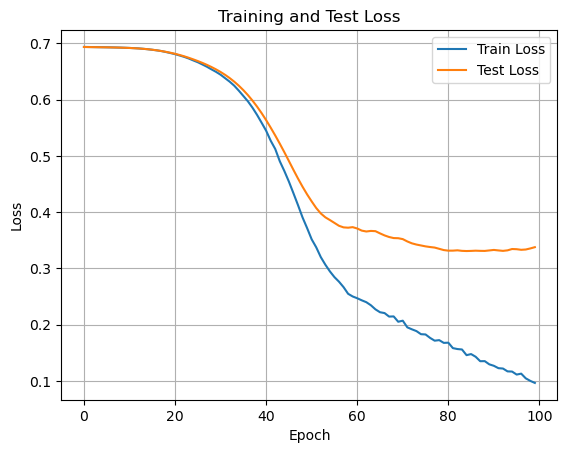

In [33]:
filename_1 = "C:/Users/ingeb/OneDrive - Danmarks Tekniske Universitet/Semester 1/Intelligent Systems 2024/3-ugers kursus/Democrats/Democrattweets_combined_clean.csv"
filename_2 = "C:/Users/ingeb/OneDrive - Danmarks Tekniske Universitet/Semester 1/Intelligent Systems 2024/3-ugers kursus/Republicans/Repub_tweets_combined_clean.csv"
import re
import numpy as np
import joblib
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
import torch 
import matplotlib.pyplot as plt
from tqdm import tqdm
import random 


torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

def tweet_list(filename): # Mainly written by myself, but with assistance from ChatGPT:
    with open(filename, mode='r', encoding='utf-8') as f:
        reader = f.read() 
    tweets = reader.strip().split('\n')
    return tweets
    
tweets_list_D = tweet_list(filename_1)
tweets_list_R = tweet_list(filename_2)


def random_testdata(tweetlist): 
    x = round(0.2 * len(tweetlist))
    test_data = []
    training_data = tweetlist.copy()
    for _ in range(x):
        chosen_element = random.choice(training_data)  
        test_data.append(chosen_element)  
        training_data.remove(chosen_element)   
    return test_data, training_data
 
test_data_R,training_data_R = random_testdata(tweets_list_R)
test_data_D, training_data_D = random_testdata(tweets_list_D)

min_size = min(len(training_data_D), len(training_data_R))

training_data_D_equal = training_data_D[:min_size]
training_data_R_equal = training_data_R[:min_size]

min_size = min(len(test_data_D), len(test_data_R))

test_data_D_equal = test_data_D[:min_size]
test_data_R_equal = test_data_R[:min_size]

full_trainingdata = np.concatenate([training_data_D_equal,training_data_R_equal])
full_testdata = np.concatenate([test_data_D_equal,test_data_R_equal])

# With assistance from ChatGPT:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(full_trainingdata)
tfidf_matrix = tfidf_matrix.toarray() 

# With assistance from ChatGPT:
svd_transformer = TruncatedSVD(n_components=300)
svd_matrix = svd_transformer.fit_transform(tfidf_matrix)

# Create y lists:
D = np.zeros(len(training_data_D_equal))
R = np.ones(len(training_data_R_equal))
y_train = np.concatenate([D, R])

D = np.zeros(len(test_data_D_equal))
R = np.ones(len(test_data_R_equal))
y_test = np.concatenate([D, R])

def preprocess_tweet(tweet,tfidf,SVD):
    tfidf_tweet = tfidf.transform(tweet)
    svd_tweet = SVD.transform(tfidf_tweet)
    return svd_tweet


# Help from TA, Jonathan. 
# Guided by examples from class and example provided by our teacher Mikkel.

# Device to use for computations
device = torch.device('cpu')

#%% Settings
weight_decay = 1e-5
learning_rate = 0.001
T = 100 # Number of epochs

def create_dataset(svd_matrix, y_liste):
    features = torch.tensor(svd_matrix, dtype=torch.float)
    labels = torch.tensor(y_liste, dtype=torch.float)
    return features, labels

x_train = svd_matrix.copy()

indices = torch.randperm(x_train.shape[0])  # Shuffle rows - assistance from ChatGPT
x_train = x_train[indices]
y_train = y_train[indices]

x_test = preprocess_tweet(full_testdata,tfidf_vectorizer,svd_transformer)

indices = torch.randperm(x_test.shape[0])  # Shuffle rows - assistance from ChatGPT
x_test = x_test[indices]
y_test = y_test[indices]

x, y = create_dataset(x_train,y_train)
x_test, y_test = create_dataset(x_test,y_test)

model = torch.nn.Sequential(
    torch.nn.Linear(300, 240), 
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(240, 128), 
    torch.nn.ReLU(),
    torch.nn.Linear(128, 64), 
    torch.nn.ReLU(),
    torch.nn.Linear(64, 16), 
    torch.nn.ReLU(),
    torch.nn.Linear(16, 1),
    torch.nn.Sigmoid(),
)
model.to(device)
x, y = x.to(device), y.to(device)

loss_fn = torch.nn.BCELoss() #Binary Crossentropy (R vs. D)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,weight_decay=weight_decay)

train_loss = np.zeros(T)
test_loss = np.zeros(T)

for t in tqdm(range(T)):
    model.train()
    y_pred = model(x).reshape(-1) 

    loss = loss_fn(y_pred, y.reshape(-1))
    
    train_loss[t] = loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()    

    # Evaluation Phase
    model.eval()
    with torch.no_grad():
        y_pred_test = model(x_test)
        test_loss[t] = loss_fn(y_pred_test, y_test.unsqueeze(1)).item()

with torch.no_grad():
    y_pred_test = model(x_test)
    y_pred_labels = (y_pred_test > 0.5).float().reshape(-1) 
    accuracy = (y_pred_labels == y_test).float().mean().item()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


plt.plot(train_loss, label="Train Loss")
plt.plot(test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss")
plt.legend()
plt.grid(True)
plt.show()

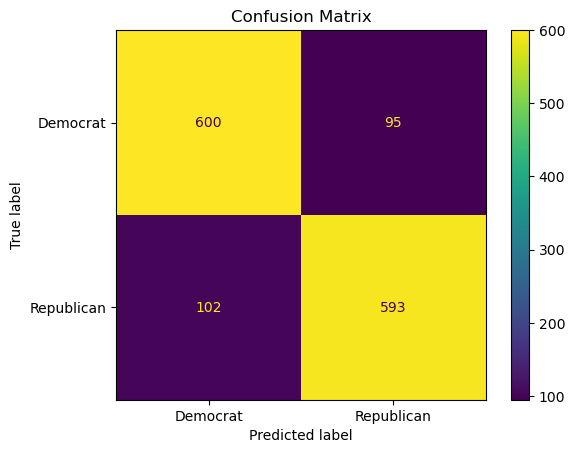

In [25]:
# From this website: https://scikit-learn.org/dev/modules/generated/sklearn.metrics.confusion_matrix.html
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Democrat", "Republican"])
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [31]:
print(600/(600+95))
print(593/(593+102))

0.8633093525179856
0.8532374100719424


In [29]:
n_success = 593  # Number of correct predictions
n_total = (593+102)
alpha = 0.05  # Significance level (95% confidence interval)

p_hat = n_success / n_total

# Critical value for 95% CI
z_obs = stats.norm.ppf(1 - alpha / 2)  

ME = z_obs * np.sqrt(p_hat * (1 - p_hat) / n_total)

# Confidence interval
ci_lower = (p_hat - ME)*100
ci_upper = (p_hat + ME)*100

print(f"95% Confidence Interval: [{ci_lower:.3f}, {ci_upper:.3f}]")

95% Confidence Interval: [82.693, 87.955]


In [30]:
import scipy.stats as stats

# From statistics book, 1. semester: https://02402.compute.dtu.dk/enotes/book-IntroStatistics-Python.pdf 

# Hypothesis whether our model is guessing (0.5 accuracy)
n_success = (y_pred_labels == y_test).sum().item()  # Number of correct predictions - this line was created with assistance from ChatGPT
n_total = len(y_test)
alpha = 0.05  # Significance level (95% confidence interval)

p_hat = n_success / n_total

# Critical value for 95% CI
z_obs = stats.norm.ppf(1 - alpha / 2)  

ME = z_obs * np.sqrt(p_hat * (1 - p_hat) / n_total)

# Confidence interval
ci_lower = (p_hat - ME)*100
ci_upper = (p_hat + ME)*100

print(f"Den estimerede effekt er beregnet til at være: {round(p_hat*100,3)}")
print(f"\n95% Confidence Interval: [{ci_lower:.3f}, {ci_upper:.3f}]")

Den estimerede effekt er beregnet til at være: 85.827

95% Confidence Interval: [83.994, 87.661]


In [34]:
print(n_success,n_total)

1202 1390


In [14]:
# Also from statistics book, from 1. semester.

p_value = 1-stats.binom.cdf(n_success-1,n_total, 0.5)

if p_value< 0.001:
    print("Strong evidence against the hypothesis")
    print(p_value)
else:
    print("Cannot reject the hypothesis")
    print(p_value)

Strong evidence against the hypothesis
0.0
